In [1]:
import sys
import os.path as o
import numpy as np
import os
import cdd
import cvxpy as cp
#sys.path.append(o.abspath(o.join(o.dirname(sys.modules[__name__].__file__), "..")))

import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [2]:
from mrg32k3a.mrg32k3a import MRG32k3a

In [3]:
sys.path.append('/Users/boomts59/Downloads/simopt-python_dev_joe/')

In [4]:
from simopt.experiment_base import ProblemSolver, read_experiment_results, post_normalize, plot_progress_curves, plot_solvability_cdfs

In [5]:
rng = MRG32k3a()

# Helper Function

In [6]:
#plotting functions, for example 
#X,Y = np.meshgrid(np.arange(?),np.arange(?))
#m,n = X.shape, Z = np.zeros((m,n))
#Z[i][j] = function(X[i][j], Y[i][j])
def surf_plot(X,Y,Z,size=(8,8)):
    fig = plt.figure(figsize=size)

    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X,Y,Z, cmap="autumn_r", rstride=25, cstride=10, alpha=0.8)
    ax.set(xlabel='X', ylabel='Y', zlabel='Simulated Function')
    fig.colorbar(surf, shrink = 0.5, aspect = 15)
    plt.show()
    
def contour_plot(X,Y,Z,size=(5,5),path=None,title="Contour Plot"):
    fig = plt.figure(figsize=size)
    
    a = plt.contour(X,Y,Z, cmap="autumn_r")
    plt.colorbar(a,shrink = 0.8, aspect = 20)
    
    #plotting solution path
    if(path is not None):
        x = path[:,0];y = path[:,1]
        u = np.diff(x);v = np.diff(y)
        pos_x = x[:-1] + u/2;pos_y = y[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 
        plt.plot(x,y, marker="o")
        plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
    
    
    plt.xlabel('X');plt.ylabel('Y')
    plt.title(title)
    plt.show()
    
def constrained_contour_plot(X,Y,Z,conZ,size=(8,6),path=None,title="Contour Plot"):
    '''
    conZ is a list of values of constraints output, i.e.
    conZ[i] is the vector of values of X,Y of constraint i
    
    path is the iterating points of the algorithm
    '''
    fig = plt.figure(figsize=size)
    
    a = plt.contour(X,Y,Z, cmap="autumn_r")
    plt.colorbar(a,shrink = 0.8, aspect = 20)
    
    #plotting constraints
    for constraint in conZ:
        cg = plt.contour(X, Y, constraint, [0])
        plt.setp(cg.collections,path_effects=[patheffects.withTickedStroke(angle=135)])
    
    #plotting solution path
    if(path is not None):
        x = path[:,0];y = path[:,1]
        u = np.diff(x);v = np.diff(y)
        pos_x = x[:-1] + u/2;pos_y = y[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 
        plt.plot(x,y, marker="o")
        plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
    
    plt.xlabel('X');plt.ylabel('Y')
    plt.title(title)
    plt.show()
    
    
def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    
    return ns

# Theoretical Derivations

## Frank Wolfe

In the normal Frank-Wolfe algorithm for linear constraints, we determine the search direction from an LP minimization of $d^Tg$ under the feasible region where $g$ is the gradient evaluated at the current iteration

For away-step Frank Wolfe, we are maintaining the coefficients of vertices to be non-negative, so we will need to determine the step size that satisfies this requirement. We are at $x^{(t)}$ and we want to move by updating the next solution so that $x^{(t+1)} = x^{(t)} + d\gamma^{*}$ and this will be the point at the polytope's boundary. We will actually move to $x^{(t)} + \gamma'\gamma^{*}d = x^{(t)} + \gamma'\gamma^{*}(x^{(t)} - v)$. Normally, at each step $x^{(t)} = \sum_{u}\alpha_u^{(t)}u$. Substitute into the next step, we have $x^{(t+1)} = \sum_{u}\alpha_u^{(t+1)}u$

$$\alpha_u^{(t+1)} = (1 + \gamma'\gamma^{*})\alpha_u^{t} \text{ where }\, u \neq v$$
$$\alpha_v^{(t+1)} = (1 + \gamma'\gamma^{*})\alpha_v^{t} - \gamma'\gamma^{*} \ge 0$$

Next, we want the coefficients ($\alpha$) to be non-negative, so we define the upper bound

$$\gamma' \le \frac{\alpha_v^{t}}{1 - \alpha_v^t}\frac{1}{\gamma^{*}}$$

# conSAN

Constrained SAN problem is a SAN problem with linear constraints on the mean of graph edges

In [7]:
from simopt.models import consan
from simopt.solvers import Boom_ProxGD
from simopt.solvers import Boom_FrankWolfe

In [8]:
arcs = [(1,2),(1,3),(2,3),(2,4),(3,4)]
#[x,2x,4,2y,y] #2D
x0 = np.array([8,16,4,4,2])
#x0 = np.array([6,12,4,12,6])


node_set = set()
for e in arcs:
    node_set.add(e[0]);node_set.add(e[1])
num_nodes = max(node_set)

#easy simple graph with two variables
Ci = np.array([[-3,0,0,0,-1], # y >= -3x + 2
              [-1,0,0,0,1], #y <= x+2
              [1/2,0,0,0,1], #y <= -x/2 + 6
              [1,0,0,0,-1], #y >= x - 6
              [0,0,1,0,0],[0,0,-1,0,0], #4
              #[-1,0,0,0,0],[0,0,0,0,-1], #x,y >= 0
              [2,-1,0,0,0],[-2,1,0,0,0], #x, 2x
              [0,0,0,1,-2],[0,0,0,-1,2]]) #y, 2y

#Ci = np.array([[-0.5,0,0,0,1],
#              [-1,0,0,0,-1],
#              [2,0,0,0,-1],
#              [0,0,1,0,0],[0,0,-1,0,0], #4
              ##[-1,0,0,0,0],[0,0,0,0,-1], #x,y >= 0
#              [2,-1,0,0,0],[-2,1,0,0,0], #x, 2x
#              [0,0,0,1,-2],[0,0,0,-1,2]]) #y, 2y

di = np.array([-2,2,6,6,4,-4,0,0,0,0])
#di = np.array([3,-4,6,4,-4,0,0,0,0])
rng = MRG32k3a()

atom_vectors = np.array([[0,0,4,4,2],
                         [2/3,4/3,4,0,0],
                         [6,12,4,0,0],
                         [8,16,4,4,2],
                         [8/3,16/3,4,28/3,14/3]])

#atom_vectors = np.array([[6,12,4,12,6],
#                         [2/3,4/3,4,20/3,10/3],
#                         [10/3,20/3,4,4/3,2/3]])


In [9]:
model_factors = {
    "num_nodes":num_nodes,
    "arcs":arcs,
    "arc_means":np.ones(len(arcs))
}

problem_factors = {
    "initial_solution":tuple(x0),
    "Ci":Ci,
    "di":di,
    "budget":10000
}

def step_size_pgd(k):
    return 1/((k+1)**(1/3))

def step_size_fw(k):
    return 1/((k+1)**(1/3))

pgd_factors = {
    "step_f":step_size_pgd,
    "max_iters":300,
    "proj_thres":0.1,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":1.0
}

fw_factors = {
    "step_f":step_size_fw,
    "max_iters":300,
    "backtrack":1,
    "theta":0.2,
    "ratio":0.8,
    "max_gamma":1.0,
    "atom_vectors":atom_vectors,
    "algorithm":"normal"
}

away_factors = fw_factors.copy()
away_factors["algorithm"] = "away"

pairwise_factors = fw_factors.copy()
pairwise_factors["algorithm"] = "pairwise"

In [10]:
#check for vertices
a,b = Ci.shape
mat = np.concatenate((di.reshape(a,1),-Ci),axis = 1)
mat = cdd.Matrix(mat,linear=False,number_type='float')

P = cdd.Polyhedron(mat)
poly = cdd.Polyhedron(mat)
ext = poly.get_generators()

V = np.array(ext)[:,1:] 

In [18]:
#this cell is for the problem with larger dimensions (13), 
#if you have defined the problem above, please don't run this cell
def step_size_pgd(k):
    return 1/np.sqrt(k+1)

def step_size_fw(k):
    return 1/np.sqrt(k+1)

Ci = -np.eye(13)
Ci = np.concatenate((Ci,np.eye(13)),axis = 0)
#c = np.random.randint(0,5,13).reshape(1,13)
c = np.ones(13).reshape(1,13)
Ci = np.concatenate((Ci,c),axis = 0)
Ci = np.concatenate((Ci,-c),axis = 0)

di = -np.ones(13) #lower bounds
di = np.concatenate((di,10*np.ones(13))) #upper bounds
#di = 10*np.ones(13) #upper bounds
di = np.concatenate((di,np.array([1000,-20])))
#di = np.concatenate((di,np.array([100,-100])))

#atom_vectors = np.eye(13)
x0 = np.array([1,1,1,1,10,10,10,10,10,10,10,10,10])

problem_factors = {
    "initial_solution":tuple(x0),
    "Ci":Ci,
    "di":di,
    "budget":3000
}

pgd_factors = {
    "step_f":step_size_pgd,
    "max_iters":300,
    "proj_thres":0.1,
    "backtrack":1,
    "max_gamma":1.0,
    "theta":0.01
}

fw_factors = {
    "step_f":step_size_fw,
    "max_iters":300,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":1.0,
    "ratio":0.7,
    "atom_vectors":None,
    "algorithm":"normal"
}

away_factors = fw_factors.copy()
away_factors["algorithm"] = "away"

pairwise_factors = fw_factors.copy()
pairwise_factors["algorithm"] = "pairwise"

In [10]:
#consan_model = consan.conSAN_model(fixed_factors = model_factors)
#consan_problem = consan.conSAN_problem(fixed_factors = problem_factors)
consan_problem = consan.conSAN_problem(fixed_factors = problem_factors,model_fixed_factors = model_factors)

In [19]:
#This cell will take a while (for plotting contours)
Xsan,Ysan = np.meshgrid(np.arange(0.1,8,0.1),np.arange(0.1,8,0.1))
m,n = Xsan.shape
Zsan = np.zeros((m,n))
Nsim = 100

consanZ = []

for i in range(4):
    values = -Ci[i][0]*Xsan - Ci[i][-1]*Ysan + di[i]
    consanZ.append(values)

for i in range(m):
    for j in range(n):
        #print(i,j)
        s = 0
        for k in range(Nsim):
            cur_model_factors = {
                                "num_nodes":num_nodes,
                                "arcs":arcs,
                                "arc_means":np.array([Xsan[i][j],2*Xsan[i][j],4,2*Ysan[i][j],Ysan[i][j]])
                                }
            cur_consan_model = consan.conSAN_model(fixed_factors = cur_model_factors)
            s += cur_consan_model.replicate([rng])[0]['longest_path_length']                              
        Zsan[i][j] = s/Nsim

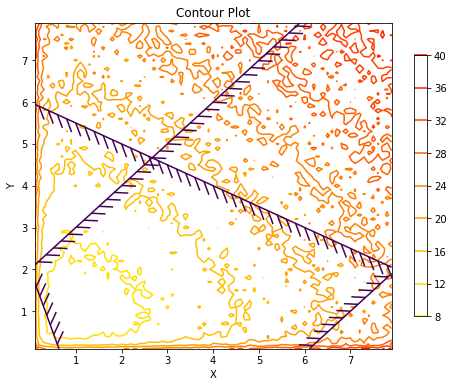

In [20]:
constrained_contour_plot(Xsan,Ysan,Zsan,consanZ)

## PGD vs FW

In [11]:
pgd_name = "Boom-PGD"
fw_name = "Boom-FW"
#solver_name = "PGD-SS"
#problem_name = "SAN-1"
problem_name = "conSAN-problem"

#print(f"Testing solver {solver_name} on problem {problem_name}.")

In [12]:
#file_name_path = "experiments/outputs/" + solver_name + "_on_" + problem_name + ".pickle"
#print(f"Results will be stored as {file_name_path}.")

In [13]:
file_name_path = "/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/"
pgd_file_path = file_name_path + pgd_name + "_on_" + problem_name + ".pickle"
fw_file_path = file_name_path + fw_name + "_on_" + problem_name + ".pickle"
#file_name_path

In [27]:
fw_experiment = ProblemSolver(solver_name=fw_name, 
                             problem=consan_problem,
                             solver_fixed_factors=fw_factors, 
                             #problem_fixed_factors=problem_factors, 
                             #model_fixed_factors=model_factors,
                             file_name_path = fw_file_path)

pgd_experiment = ProblemSolver(solver_name=pgd_name, 
                             problem=consan_problem,
                             solver_fixed_factors=pgd_factors, 
                             #problem_fixed_factors=problem_factors, 
                             #model_fixed_factors=model_factors,
                             file_name_path = pgd_file_path)

experiments = [pgd_experiment,fw_experiment]

In [24]:
for e in experiments:
    e.run(n_macroreps=10)
    e.post_replicate(n_postreps=100)
    
post_normalize(experiments, n_postreps_init_opt=100)

In [14]:
fw_experiment = ProblemSolver(solver_name=fw_name, 
                             problem=consan_problem,
                             solver_fixed_factors=away_factors, 
                             file_name_path = fw_file_path)

In [6]:
#pgd_experiment.post_replicate(n_postreps=100)
#post_normalize([pgd_experiment], n_postreps_init_opt=100)
#print("max gamma <= 1")
#plot_progress_curves(experiments=[pgd_experiment], plot_type="mean", normalize=False)

In [7]:
#fw_experiment.post_replicate(n_postreps=100)
#post_normalize([fw_experiment], n_postreps_init_opt=100)
#print("max gamma at bounds")
#plot_progress_curves(experiments=[fw_experiment], plot_type="mean", normalize=False)

In [25]:
#fw_experiment.run(n_macroreps=1)

In [28]:
#pgd_experiment.run(n_macroreps=1)

In [15]:
fw_experiment.run(n_macroreps=1)

forward step direction:  [0.66666667 1.33333333 4.         0.         0.        ]
foward
Displaying Alphas:
(0.0, 0.0, 4.0, 4.0, 2.0)
-6.066401744135605e-13
**************
(0.6666666666666666, 1.3333333333333333, 4.0, 0.0, 0.0)
0.8000000000005014
**************
(6.0, 12.0, 4.0, 0.0, 0.0)
3.772185364941072e-12
**************
(8.0, 16.0, 4.0, 4.0, 2.0)
0.19999999999655335
**************
(2.6666666666666665, 5.333333333333333, 4.0, 9.333333333333334, 4.666666666666667)
1.3839795294390313e-12
**************
obj:  [17.42703017]
--------------
--------------
forward step direction:  [2.66666667 5.33333333 4.         9.33333333 4.66666667]
foward
Displaying Alphas:
(0.0, 0.0, 4.0, 4.0, 2.0)
-6.066401744135605e-13
**************
(0.6666666666666666, 1.3333333333333333, 4.0, 0.0, 0.0)
0.6322278400003962
**************
(6.0, 12.0, 4.0, 0.0, 0.0)
2.9811007566953815e-12
**************
(8.0, 16.0, 4.0, 4.0, 2.0)
0.15805695999727615
**************
(2.6666666666666665, 5.333333333333333, 4.0, 9.33333

In [29]:
#print("WITHOUT Backtracking")
#plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

In [30]:
#print("WITH Backtracking")
#plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

In [16]:
path_values = fw_experiment.all_recommended_xs[0]
path_values = np.array(path_values)[:,[0,-1]]
path_values

array([[8.        , 2.        ],
       [2.13333333, 0.4       ],
       [2.24518144, 1.29478485],
       [1.16483623, 1.16239566],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344],
       [1.54060334, 1.20844344]])

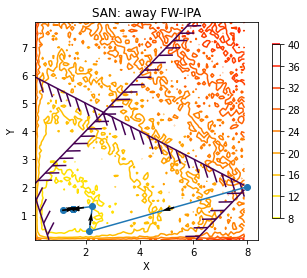

In [27]:
constrained_contour_plot(Xsan,Ysan,Zsan,consanZ,path=np.array(path_values)[:,[0,-1]],size=(5,4),title="SAN: away FW-IPA")

In [29]:
#sys.path.append('/Users/boomts59/Downloads/simopt-python_dev_joe/experiments')

In [17]:
#plot_progress_curves(experiments=[pgd_experiment,fw_experiment], plot_type="all", normalize=False)
#plot_progress_curves(experiments=[pgd_experiment,fw_experiment], plot_type="mean", normalize=False)
#plot_progress_curves(experiments=[pgd_experiment,fw_experiment], plot_type="quantile", beta=0.90, normalize=False)
#plot_solvability_cdfs(experiments=[pgd_experiment,fw_experiment], solve_tol=0.1)

## FWs: Varying parameters

In [24]:
x0 = np.array([1,1,1,1,10,10,10,10,10,10,10,10,10])

def step_size_fw(k):
    return 1/((k+1)**(1/3))

problem_factors = {
    "initial_solution":tuple(x0),
    "Ci":Ci,
    "di":di,
    "budget":1000
}
consan_problem = consan.conSAN_problem(fixed_factors = problem_factors)

fw_factors = {
    "step_f":step_size_fw,
    "max_iters":300,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":0.5,
    "atom_vectors":None,
    "algorithm":"normal"
}

away_factors = fw_factors.copy()
away_factors["algorithm"] = "away"

pairwise_factors = fw_factors.copy()
pairwise_factors["algorithm"] = "pairwise"

$f(x_{k+1}) \le f(x_k) + \theta \alpha \nabla f^T(x_k)d$

(Theta, max_gamma): (0.02,0.7)


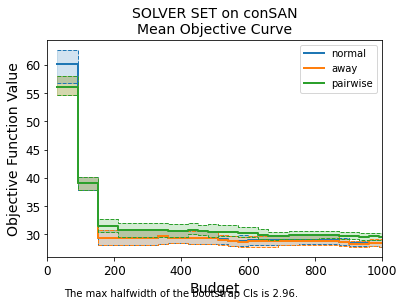

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,0.7)


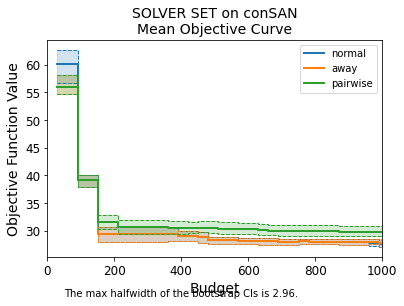

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,0.7)


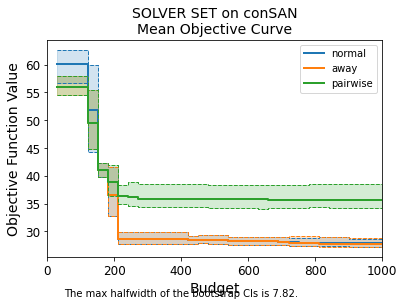

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,0.7)


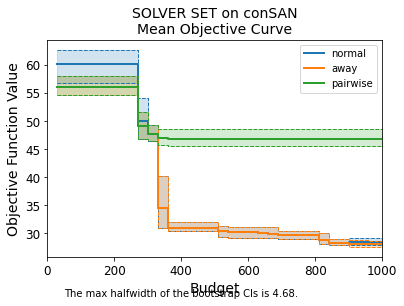

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.8,0.7)


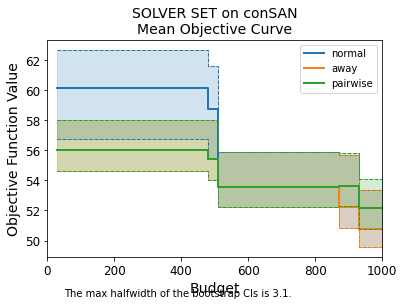

--------------------------------------------------------------------------------------


In [16]:
thetas = [0.02,0.1,0.3,0.5,0.8]
#thetas = [0.2]
#max_gammas = [0.5,0.7,0.9,1.0]
max_gammas = [0.7]
#is_backtrack = [1,0]

num_algos = 3

#without backtrcking
for theta in thetas:
    for max_gamma in max_gammas:
        #print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        
        #defining factors
        fw_factors["max_gamma"] = max_gamma
        fw_factors["theta"] = theta
        fw_factors["backtrack"] = 1
        
        away_factors = fw_factors.copy()
        away_factors["algorithm"] = "away"

        pairwise_factors = fw_factors.copy()
        pairwise_factors["algorithm"] = "pairwise"
        
        experiments = []
        factors = [fw_factors,away_factors,pairwise_factors]
        names = ["normal", "away","pairwise"]
        
        for i in range(num_algos):
        
            #print("Algo: ", names[i])
            cur_experiment = ProblemSolver(solver_name=fw_name, 
                                          solver_rename=names[i],
                                         #problem_name=problem_name,
                                           problem = consan_problem,
                                         solver_fixed_factors=factors[i], 
                                         problem_fixed_factors=problem_factors, 
                                         #model_fixed_factors=model_factors,
                                         file_name_path = fw_file_path)
            experiments.append(cur_experiment)
            cur_experiment.run(n_macroreps=5)


            cur_experiment.post_replicate(n_postreps=100)
            
        print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        post_normalize(experiments, n_postreps_init_opt=100)
        plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)
        #plot_solvability_cdfs(experiments=experiments, solve_tol=0.1)
        plt.show()
        print("--------------------------------------------------------------------------------------")

(Theta, max_gamma): (0.2,0.2)


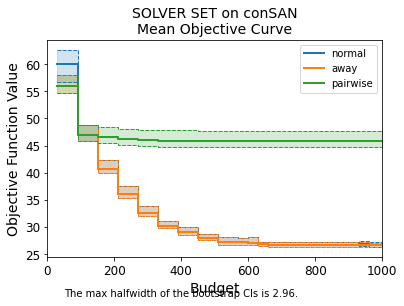

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.2,0.3)


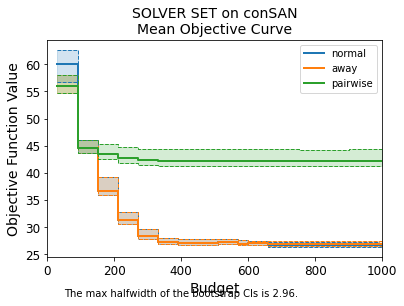

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.2,0.5)


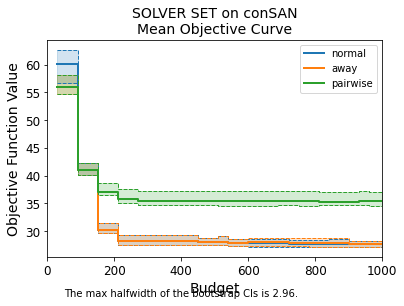

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.2,0.7)


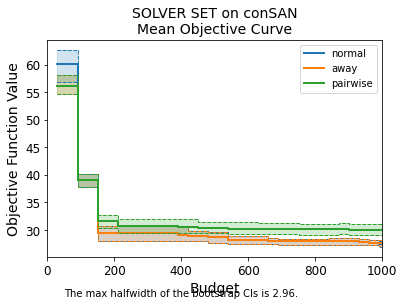

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.2,0.9)


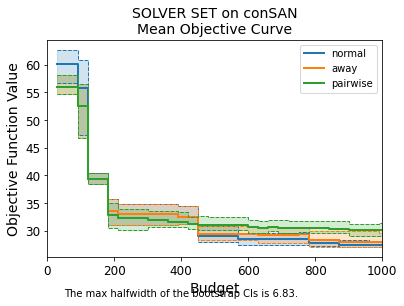

--------------------------------------------------------------------------------------


In [15]:
thetas = [0.2]
#thetas = [0.2]
max_gammas = [0.2,0.3,0.5,0.7,0.9]
#is_backtrack = [1,0]

num_algos = 3

#without backtrcking
for theta in thetas:
    for max_gamma in max_gammas:
        #print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        
        #defining factors
        fw_factors["max_gamma"] = max_gamma
        fw_factors["theta"] = theta
        fw_factors["backtrack"] = 1
        
        away_factors = fw_factors.copy()
        away_factors["algorithm"] = "away"

        pairwise_factors = fw_factors.copy()
        pairwise_factors["algorithm"] = "pairwise"
        
        experiments = []
        factors = [fw_factors,away_factors,pairwise_factors]
        names = ["normal", "away","pairwise"]
        
        for i in range(num_algos):
        
            #print("Algo: ", names[i])
            cur_experiment = ProblemSolver(solver_name=fw_name, 
                                          solver_rename=names[i],
                                         #problem_name=problem_name,
                                           problem = consan_problem,
                                         solver_fixed_factors=factors[i], 
                                         problem_fixed_factors=problem_factors, 
                                         #model_fixed_factors=model_factors,
                                         file_name_path = fw_file_path)
            experiments.append(cur_experiment)
            cur_experiment.run(n_macroreps=5)


            cur_experiment.post_replicate(n_postreps=100)
            
        print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        post_normalize(experiments, n_postreps_init_opt=100)
        plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)
        #plot_solvability_cdfs(experiments=experiments, solve_tol=0.1)
        plt.show()
        print("--------------------------------------------------------------------------------------")

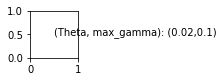

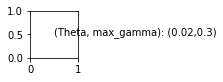

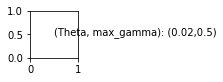

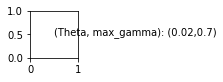

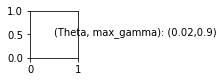

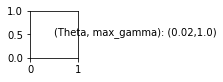

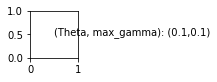

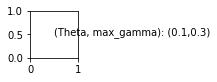

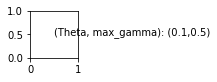

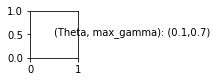

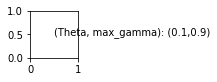

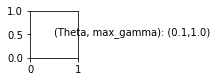

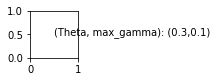

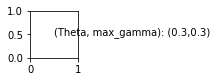

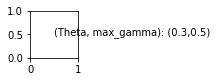

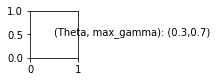

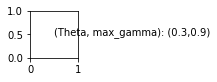

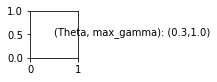

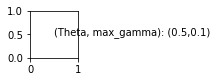

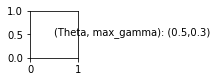

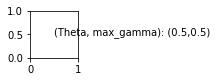

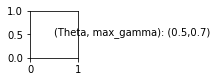

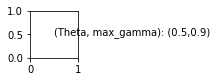

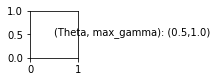

In [18]:
#with backtracking and all combinations
thetas = [0.02,0.1,0.3,0.5]
#thetas = [0.2]
max_gammas = [0.1,0.3,0.5,0.7,0.9,1.0]
#max_gammas = [0.7]

num_algos = 3
count = 1

rows, cols = len(thetas), len(max_gammas)
fig, ax = plt.subplots(rows, cols)

#without backtrcking
#for theta in thetas:
#    for max_gamma in max_gammas:
for i in range(rows):
    for j in range(cols):
        #print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        
        #defining factors
        fw_factors["max_gamma"] = max_gammas[j]
        fw_factors["theta"] = thetas[i]
        fw_factors["backtrack"] = 1
        
        away_factors = fw_factors.copy()
        away_factors["algorithm"] = "away"

        pairwise_factors = fw_factors.copy()
        pairwise_factors["algorithm"] = "pairwise"
        
        experiments = []
        factors = [fw_factors,away_factors,pairwise_factors]
        names = ["normal", "away","pairwise"]
        
        for k in range(num_algos):
        
            #print("Algo: ", names[i])
            cur_experiment = ProblemSolver(solver_name=fw_name, 
                                          solver_rename=names[k],
                                         #problem_name=problem_name,
                                           problem = consan_problem,
                                         solver_fixed_factors=factors[k], 
                                         problem_fixed_factors=problem_factors, 
                                         #model_fixed_factors=model_factors,
                                         file_name_path = fw_file_path)
            experiments.append(cur_experiment)
            cur_experiment.run(n_macroreps=10)


            cur_experiment.post_replicate(n_postreps=100)
            
        #print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        post_normalize(experiments, n_postreps_init_opt=100)
        plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)
        #plot_solvability_cdfs(experiments=experiments, solve_tol=0.1)
        #ax[i,j].plot(4,6,count)
        #ax[i,j].text(0.5,0.5,"(Theta, max_gamma): (" + str(thetas[i]) + "," + str(max_gammas[j]) + ")")
        count += 1
        plt.show()
        #print("--------------------------------------------------------------------------------------")

# Bus Schedule

In [40]:
pgd_name = "Boom-PGD"
fw_name = "Boom-FW"
#solver_name = "PGD-SS"
problem_name = "bus-problem"
#problem_name = "CASCADE-1"

In [41]:
file_name_path = "/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/"
pgd_file_path = file_name_path + pgd_name + "_on_" + problem_name + ".pickle"
fw_file_path = file_name_path + fw_name + "_on_" + problem_name + ".pickle"

In [42]:
from simopt.models import bus_schedule
from simopt.solvers import Boom_ProxGD

In [34]:
#bus_model = bus_schedule.bus_model(fixed_factors = model_factors)
#bus_problem = bus_schedule.bus_problem(fixed_factors = problem_factors,model_fixed_factors = model_factors)

In [60]:
#decision variable = x "scheduled bus time"
#1 person coming per "arrival rate" time
arrival_rate = 0.1
num_buses = 2
#num_buses = 5

#x0 = np.array([0.8,0.4])
x0 = np.array([1,0.3])

#inequality constraints for two variables
#0 <= x <= y <= 1
#Ci = np.array([[1,-1], # x<= y
 #             [-1,-1], #x + y <= b1
 #             [0,1], # y <= 0.8
 #             [1,0],[0,1], #x,y <= 1
 #             [-1,0],[0,-1]]) # 0 <= x,y

Ci = np.array([[2.8/3,1], # -2.8/3x + y <= 3.7/3
              [-0.8,1], #y <= 0.8x + 0.8
              [-2,-1], # -2x-y <= -0.5
              [1,-1],
              [1,0],[0,1], #x,y <= 1
              [-1,0],[0,-1]]) # 0 <= x,y

#di = np.array([0,-1,0.8,1,1,0,0])#.reshape(1,7)
di = np.array([3.7/3,0.8,-0.5,0.7,1,1,0,0])#.reshape(1,7)

#atom_vectors = np.array([[0.5,0.5],
#                         [0.2,0.8]])
atom_vectors = np.array([[0.25,1.0],
                         [0,0.8],
                         [0,0.5],
                         [0.25,0],
                         [0.7,0],
                         [1,0.3]])
rng = MRG32k3a()

In [61]:
model_factors = {
    "num_buses":num_buses,
    "arrival_rate":arrival_rate,
    #"scheduled_time":0.5*np.ones(num_buses)
    "scheduled_time":(0.8,0.4)
}

problem_factors = {
    "initial_solution":tuple(x0),
    "budget":3000,
    "Ci":Ci,
    "di":di
}

def step_size(k):
    return 1/(k+1)

pgd_factors = {
    "step_f":step_size,
    "max_iters":300,
    "proj_thres":0.1,
    "backtrack":1
}

fw_factors = {
    "step_f":step_size,
    "max_iters":300,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":1.0,
    "atom_vectors":atom_vectors,
    "algorithm":"normal"
}

away_factors = fw_factors.copy()
away_factors["algorithm"] = "away"

pairwise_factors = fw_factors.copy()
pairwise_factors["algorithm"] = "pairwise"

In [11]:
#more difficult bus problem
arrival_rate = 0.02
num_buses = 5

#x0 = 0.8*np.ones(num_buses)
x0 = np.array([0,0,0,0,1])

Ci = -np.eye(num_buses)
Ci = np.concatenate((Ci,np.eye(num_buses)),axis = 0)
#c = np.random.randint(0,3,num_buses).reshape(1,num_buses)
#c = np.ones(num_buses).reshape(1,num_buses)
#Ci = np.concatenate((Ci,c),axis = 0)
#Ci = np.concatenate((Ci,-c),axis = 0)

di = np.zeros(num_buses) #lower bound
di = np.concatenate((di,np.ones(num_buses))) #upper bound
#di = np.concatenate((di,np.array([1])))

#symmetry breaking
#sorting variables v1 <= v2 <= ... <= v_{num_buses}
sorting_mat = np.eye(num_buses-1,num_buses)-np.eye(num_buses-1,num_buses,1)
Ci = np.concatenate((Ci,sorting_mat),axis = 0)
di = np.concatenate((di,np.zeros(num_buses-1)))

In [12]:
model_factors = {
    "num_buses":num_buses,
    "arrival_rate":arrival_rate,
    "scheduled_time":tuple(x0)
}

problem_factors = {
    "initial_solution":tuple(x0),
    "budget":10000,
    "Ci":Ci,
    "di":di
}

def step_size(k):
    return 1/(k+1)

pgd_factors = {
    "step_f":step_size,
    "max_iters":300,
    "proj_thres":0.1,
    "theta":0.2,
    "max_gamma":0.7,
    "backtrack":1
}

fw_factors = {
    "step_f":step_size,
    "max_iters":300,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":0.7,
    #"atom_vectors":atom_vectors,
    "algorithm":"normal"
}

away_factors = fw_factors.copy()
away_factors["algorithm"] = "away"

pairwise_factors = fw_factors.copy()
pairwise_factors["algorithm"] = "pairwise"

In [13]:
a,b = Ci.shape
mat = np.concatenate((di.reshape(a,1),-Ci),axis = 1)
mat = cdd.Matrix(mat,linear=False,number_type='float')

P = cdd.Polyhedron(mat)
poly = cdd.Polyhedron(mat)
ext = poly.get_generators()

In [45]:
Xbus,Ybus = np.meshgrid(np.arange(0.025,1,0.025),np.arange(0.025,1,0.025))
m,n = Xbus.shape
Zbus = np.zeros((m,n))
Nsim = 100

bus_constr = []

for i in range(4):
    values = -Ci[i][0]*Xbus - Ci[i][-1]*Ybus + di[i]
    bus_constr.append(values)

for i in range(m):
    for j in range(n):
        #print(i,j)
        s = 0
        for k in range(Nsim):
            cur_model_factors = {
                                "num_buses":num_buses,
                                "arrival_rate":arrival_rate,
                                "scheduled_time":(Xbus[i][j],Ybus[i][j])
                                }
            cur_bus_model = bus_schedule.bus_model(fixed_factors = cur_model_factors)
            s += cur_bus_model.replicate([rng])[0]["total_waiting_time"]                              
        Zbus[i][j] = s/Nsim

In [9]:
#bus_model.replicate([rng])

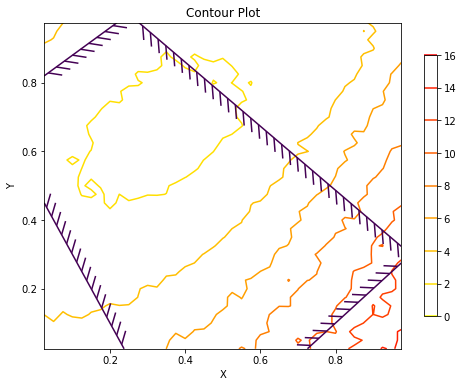

In [47]:
constrained_contour_plot(Xbus,Ybus,Zbus,bus_constr)

## PGD vs FW

In [50]:
fw_experiment = ProblemSolver(solver_name=fw_name, 
                             problem_name=problem_name,
                             solver_fixed_factors=fw_factors, 
                             problem_fixed_factors=problem_factors, 
                             model_fixed_factors=model_factors,
                             file_name_path = fw_file_path)

pgd_experiment = ProblemSolver(solver_name=pgd_name, 
                             problem_name=problem_name,
                             solver_fixed_factors=pgd_factors, 
                             problem_fixed_factors=problem_factors, 
                             model_fixed_factors=model_factors,
                             file_name_path = pgd_file_path)

In [24]:
experiments = [pgd_experiment,fw_experiment]
for e in experiments:
    e.run(n_macroreps=10)
    e.post_replicate(n_postreps=100)
    
post_normalize(experiments, n_postreps_init_opt=100)

In [15]:
fw_experiment.post_replicate(n_postreps=100)
post_normalize([fw_experiment], n_postreps_init_opt=100)

In [62]:
bus_problem = bus_schedule.bus_problem(fixed_factors = problem_factors,model_fixed_factors = model_factors)
fw_experiment = ProblemSolver(solver_name=fw_name, 
                             problem=bus_problem,
                             solver_fixed_factors=away_factors, 
                             file_name_path = fw_file_path)

In [63]:
fw_experiment.run(n_macroreps=1)

foward
Displaying Alphas:
(0.25, 1.0)
0.0
**************
(0.0, 0.8)
1.0
**************
(0.0, 0.5)
0.0
**************
(0.25, 0.0)
0.0
**************
(0.7, 0.0)
0.0
**************
(1.0, 0.3)
0.0
**************
max_gamma:  1.0
gamma:  1.0
obj:  [3.37226252]
--------------
foward
Displaying Alphas:
(0.25, 1.0)
0.0
**************
(0.0, 0.8)
0.5903999999999998
**************
(0.0, 0.5)
0.0
**************
(0.25, 0.0)
0.0
**************
(0.7, 0.0)
0.40960000000000013
**************
(1.0, 0.3)
0.0
**************
max_gamma:  1.0
gamma:  0.40960000000000013
obj:  [2.11290252]
--------------
foward
Displaying Alphas:
(0.25, 1.0)
0.40960000000000013
**************
(0.0, 0.8)
0.3485721599999998
**************
(0.0, 0.5)
0.0
**************
(0.25, 0.0)
0.0
**************
(0.7, 0.0)
0.24182784
**************
(1.0, 0.3)
0.0
**************
max_gamma:  1.0
gamma:  0.40960000000000013
obj:  [1.86116316]
--------------
foward
Displaying Alphas:
(0.25, 1.0)
0.3408805232640001
**************
(0.0, 0.8)
0.2900

In [56]:
fw_experiment.run(n_macroreps=1)

foward
Displaying Alphas:
(0.25, 1.0)
1.2137360835014595e-11
**************
(0.0, 0.8)
0.7000000000066269
**************
(0.0, 0.5)
5.862585852188709e-12
**************
(0.25, 0.0)
8.435464147173392e-12
**************
(0.7, 0.0)
2.683336108741908e-11
**************
(1.0, 0.3)
0.2999999999497726
**************
max_gamma:  0.7
gamma:  0.7
obj:  [1.72059585]
--------------
foward
Displaying Alphas:
(0.25, 1.0)
1.155350967513784e-11
**************
(0.0, 0.8)
0.6663274564056682
**************
(0.0, 0.5)
5.5805741697311094e-12
**************
(0.25, 0.0)
8.029687669620061e-12
**************
(0.7, 0.0)
2.5542578914322172e-11
**************
(1.0, 0.3)
0.3336725435528287
**************
max_gamma:  0.7
gamma:  0.04810363371520002
obj:  [1.70054346]
--------------
away
Displaying Alphas:
(0.25, 1.0)
1.1553509675138909e-11
**************
(0.0, 0.8)
0.6663274564057299
**************
(0.0, 0.5)
5.580574169731626e-12
**************
(0.25, 0.0)
7.937111673724246e-12
**************
(0.7, 0.0)
2.55425789

['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_BUS_mean_prog_curve_unnorm.png']

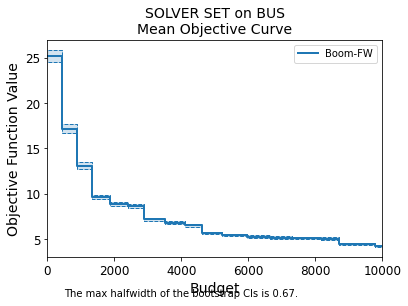

In [16]:
plot_progress_curves(experiments=[fw_experiment], plot_type="mean", normalize=False)

In [103]:
#pgd_experiment.all_recommended_xs[0]

WITHOUT backtrack


['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_BUS_mean_prog_curve_unnorm.png']

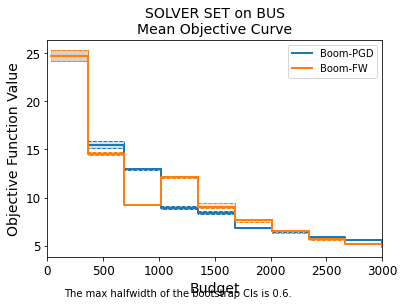

In [28]:
print("WITHOUT backtrack")
plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

WITH backtrack


['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_BUS_mean_prog_curve_unnorm.png']

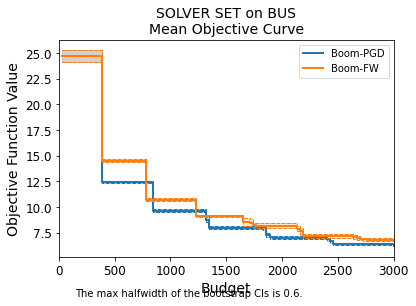

In [25]:
print("WITH backtrack")
plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

In [64]:
path_values = fw_experiment.all_recommended_xs[0]
path_values = np.array(path_values)
path_values

array([[1.        , 0.3       ],
       [0.        , 0.8       ],
       [0.28672   , 0.47232   ],
       [0.27167949, 0.68845773],
       [0.39387139, 0.62328534],
       [0.34450576, 0.72379498],
       [0.38054193, 0.7004966 ],
       [0.32946646, 0.67358641],
       [0.32946646, 0.67358641]])

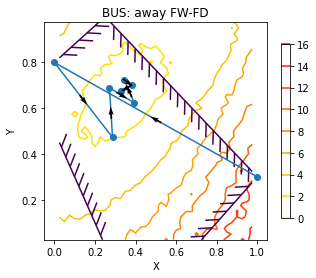

In [66]:
constrained_contour_plot(Xbus,Ybus,Zbus,bus_constr,path=np.array(path_values),size=(5,4),title="BUS: away FW-FD")

In [29]:
#plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

In [13]:
#plot_progress_curves(experiments=[pgd_experiment,fw_experiment], plot_type="all", normalize=False)
#plot_progress_curves(experiments=[pgd_experiment,fw_experiment], plot_type="mean", normalize=False)
#plot_progress_curves(experiments=[pgd_experiment,fw_experiment], plot_type="quantile", beta=0.90, normalize=False)
#plot_solvability_cdfs(experiments=[pgd_experiment,fw_experiment], solve_tol=0.1)

## FWs

In [44]:
post_normalize(experiments, n_postreps_init_opt=100)

In [27]:
#plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

In [36]:
model_factors = {
    "num_buses":num_buses,
    "arrival_rate":arrival_rate,
    "scheduled_time":tuple(x0)
}

problem_factors = {
    "initial_solution":tuple(x0),
    "budget":2000,
    "Ci":Ci,
    "di":di
}

bus_problem = bus_schedule.bus_problem(fixed_factors = problem_factors,model_fixed_factors = model_factors)

def step_size(k):
    return 1/(k+1)

fw_factors = {
    "step_f":step_size,
    "max_iters":300,
    "backtrack":0,
    "theta":0.2,
    "max_gamma":0.7,
    #"atom_vectors":atom_vectors,
    "algorithm":"normal"
}

away_factors = fw_factors.copy()
away_factors["algorithm"] = "away"

pairwise_factors = fw_factors.copy()
pairwise_factors["algorithm"] = "pairwise"

(Theta, max_gamma): (0.01,0.7)


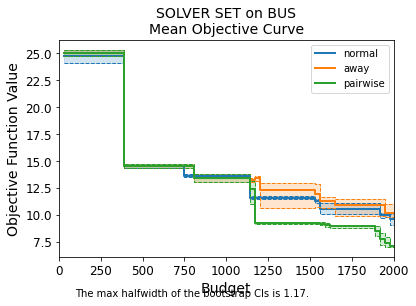

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.05,0.7)


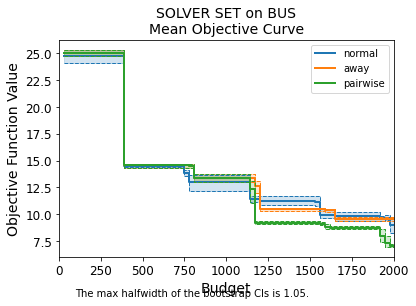

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,0.7)


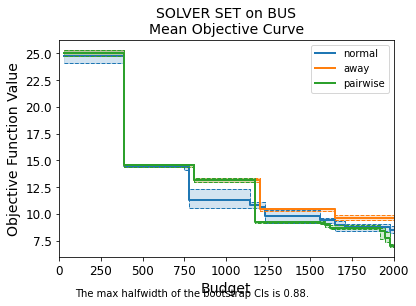

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,0.7)


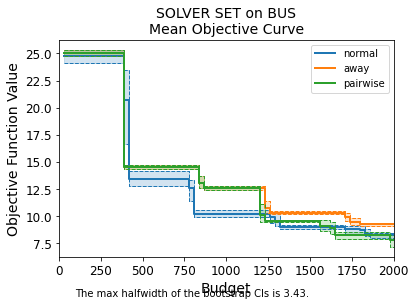

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,0.7)


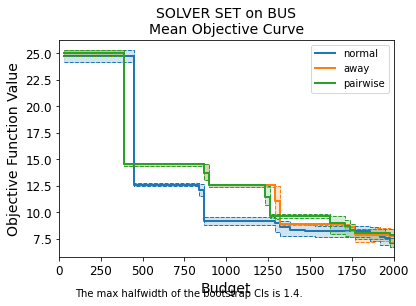

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.8,0.7)


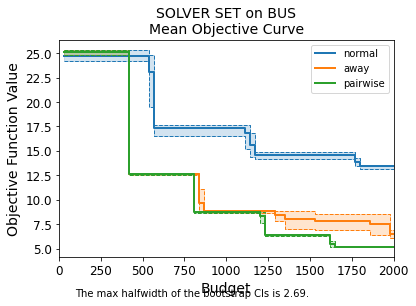

--------------------------------------------------------------------------------------


In [38]:
#without backtracking
thetas = [0.01,0.05,0.1,0.3,0.5,0.8]
#thetas = [0.2]
#max_gammas = [0.5,0.7,0.9,1.0]
max_gammas = [0.7]
#is_backtrack = [1,0]

num_algos = 3

#without backtrcking
for theta in thetas:
    for max_gamma in max_gammas:
        #print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        
        #defining factors
        fw_factors["max_gamma"] = max_gamma
        fw_factors["theta"] = theta
        fw_factors["backtrack"] = 1
        
        away_factors = fw_factors.copy()
        away_factors["algorithm"] = "away"

        pairwise_factors = fw_factors.copy()
        pairwise_factors["algorithm"] = "pairwise"
        
        experiments = []
        factors = [fw_factors,away_factors,pairwise_factors]
        names = ["normal", "away","pairwise"]
        
        for i in range(num_algos):
        
            #print("Algo: ", names[i])
            cur_experiment = ProblemSolver(solver_name=fw_name, 
                                          solver_rename=names[i],
                                         #problem_name=problem_name,
                                           problem = bus_problem,
                                         solver_fixed_factors=factors[i], 
                                         problem_fixed_factors=problem_factors, 
                                         model_fixed_factors=model_factors,
                                         file_name_path = fw_file_path)
            experiments.append(cur_experiment)
            cur_experiment.run(n_macroreps=5)


            cur_experiment.post_replicate(n_postreps=100)
            
        print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        post_normalize(experiments, n_postreps_init_opt=100)
        plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)
        #plot_solvability_cdfs(experiments=experiments, solve_tol=0.1)
        plt.show()
        print("--------------------------------------------------------------------------------------")

(Theta, max_gamma): (0.02,0.1)


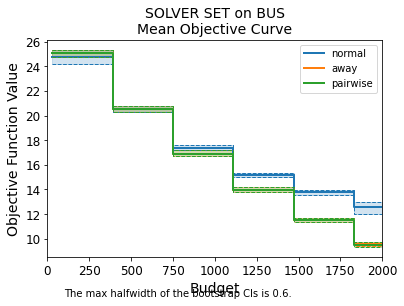

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.02,0.3)


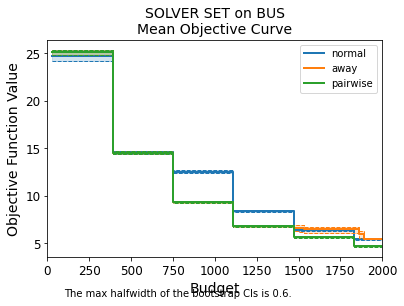

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.02,0.5)


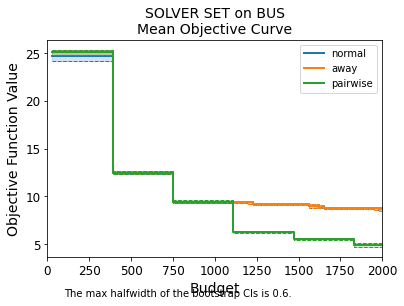

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.02,0.7)


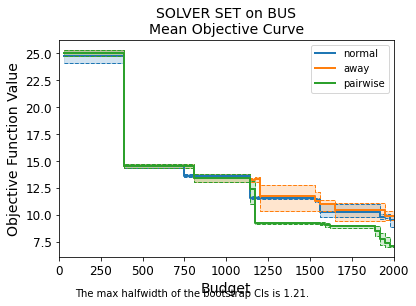

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.02,0.9)


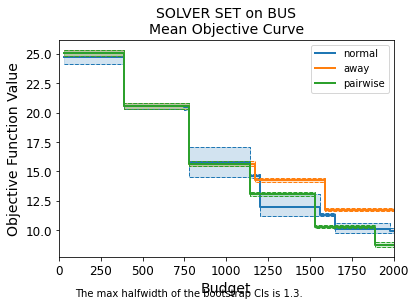

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.02,1.0)


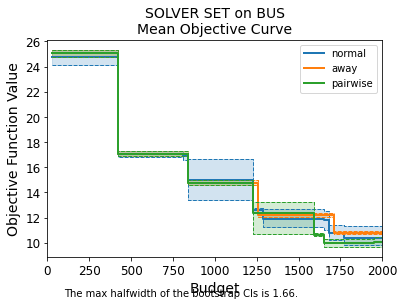

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,0.1)


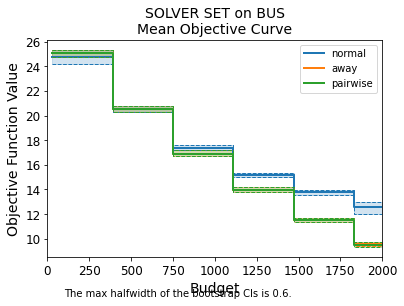

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,0.3)


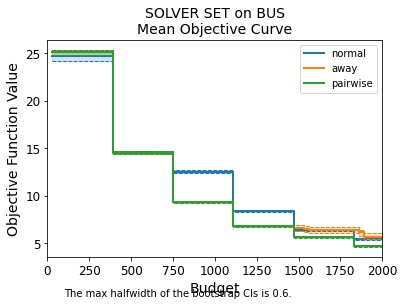

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,0.5)


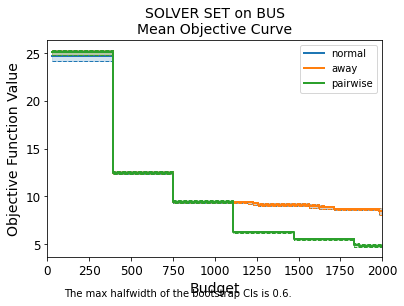

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,0.7)


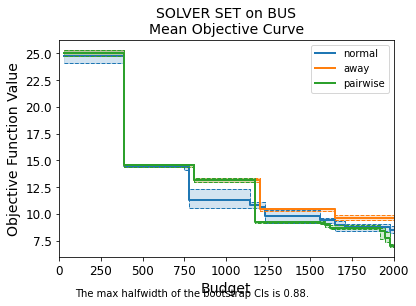

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,0.9)


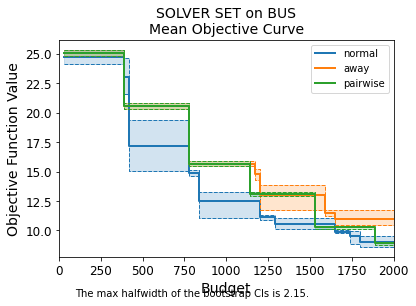

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.1,1.0)


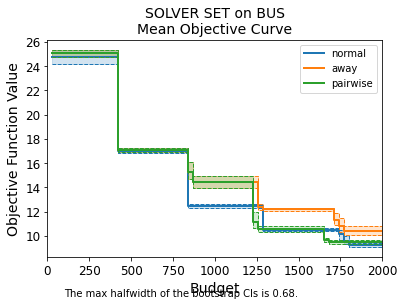

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,0.1)


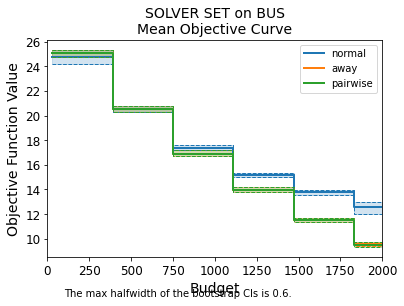

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,0.3)


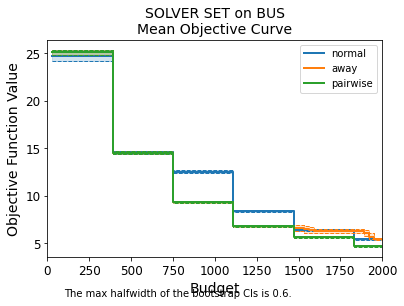

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,0.5)


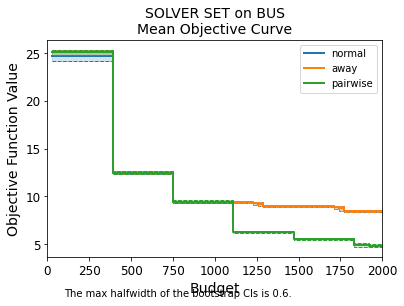

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,0.7)


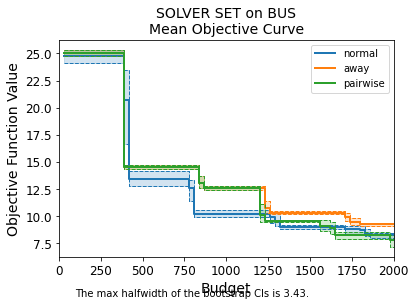

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,0.9)


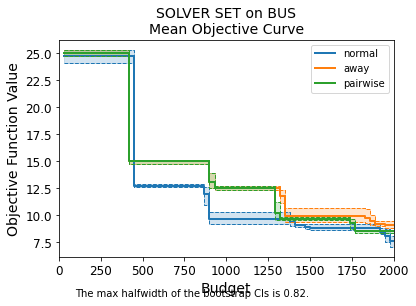

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.3,1.0)


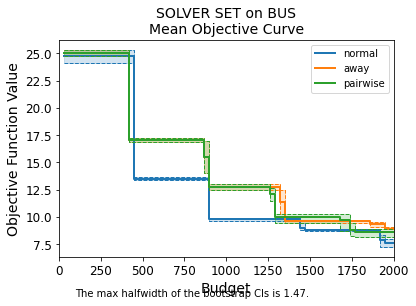

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,0.1)


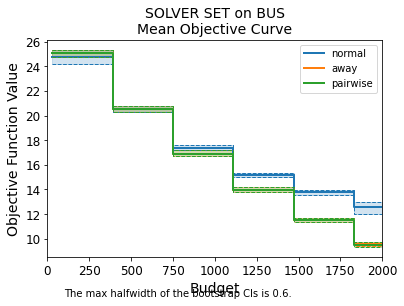

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,0.3)


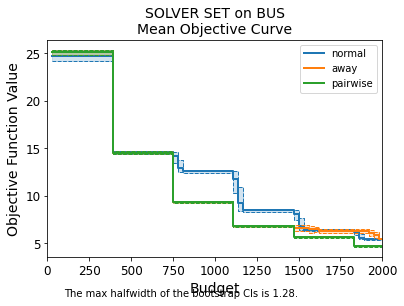

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,0.5)


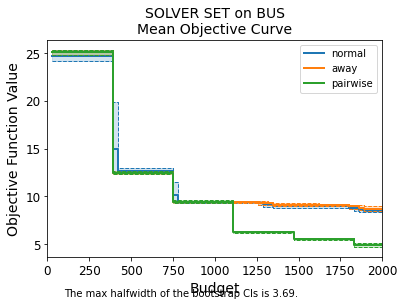

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,0.7)


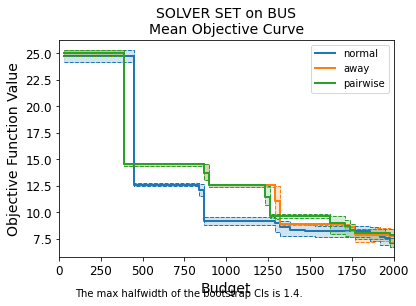

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,0.9)


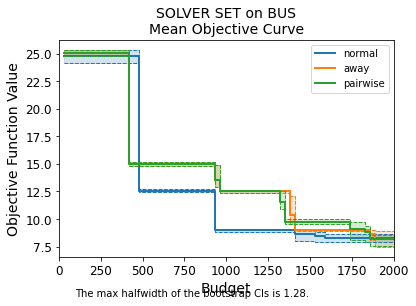

--------------------------------------------------------------------------------------
(Theta, max_gamma): (0.5,1.0)


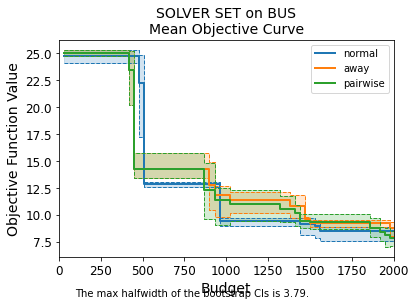

--------------------------------------------------------------------------------------


In [35]:
#with backtracking and all combinations
thetas = [0.02,0.1,0.3,0.5]
#thetas = [0.2]
max_gammas = [0.1,0.3,0.5,0.7,0.9,1.0]
#max_gammas = [0.7]
#is_backtrack = [1,0]

num_algos = 3

#without backtrcking
for theta in thetas:
    for max_gamma in max_gammas:
        #print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        
        #defining factors
        fw_factors["max_gamma"] = max_gamma
        fw_factors["theta"] = theta
        fw_factors["backtrack"] = 1
        
        away_factors = fw_factors.copy()
        away_factors["algorithm"] = "away"

        pairwise_factors = fw_factors.copy()
        pairwise_factors["algorithm"] = "pairwise"
        
        experiments = []
        factors = [fw_factors,away_factors,pairwise_factors]
        names = ["normal", "away","pairwise"]
        
        for i in range(num_algos):
        
            #print("Algo: ", names[i])
            cur_experiment = ProblemSolver(solver_name=fw_name, 
                                          solver_rename=names[i],
                                         #problem_name=problem_name,
                                           problem = bus_problem,
                                         solver_fixed_factors=factors[i], 
                                         problem_fixed_factors=problem_factors, 
                                         model_fixed_factors=model_factors,
                                         file_name_path = fw_file_path)
            experiments.append(cur_experiment)
            cur_experiment.run(n_macroreps=5)


            cur_experiment.post_replicate(n_postreps=100)
            
        print("(Theta, max_gamma): (" + str(theta) + "," + str(max_gamma) + ")")
        post_normalize(experiments, n_postreps_init_opt=100)
        plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)
        #plot_solvability_cdfs(experiments=experiments, solve_tol=0.1)
        plt.show()
        print("--------------------------------------------------------------------------------------")

# Other problems

# Other Problems

In [34]:
from simopt.models import cntnv

In [35]:
cnt_model = cntnv.CntNV()

In [47]:
p_OHCA = np.array([[0.05,0.05,0.05],
                   [0.05,0.05,0.1],
                   [0.25,0.2,0.2]])

#p_OHCA = np.array([[0.05,0.05],
#                   [0.05,0.05]])

In [49]:
#problem_name = "VOLUNTEER-1"
problem_name = "VOLUNTEER-2"
#problem_name = "CNTNEWS-1"
#problem_name = "MM1-1"

pgd_name = "Boom-PGD"
fw_name = "Boom-FW"

file_name_path = "/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/"
pgd_file_path = file_name_path + pgd_name + "_on_" + problem_name + ".pickle"
fw_file_path = file_name_path + fw_name + "_on_" + problem_name + ".pickle"

def pgd_step_size(k):
    return 1/(k+1)

def fw_step_size(k):
    return 1/(k+1)

model_factors = {
    "num_squares":9,
    "num_OHCA":100,
    "mean_vol":100,
    "thre_dist":100.0
}

problem_factors = {
    "budget":2000,
    "initial_solution":[1,0,0,0,0,0,0,0,0],
    "p_OHCA":p_OHCA,
    #"initial_solution":[0,0.5,0.5,0]
}

pgd_factors = {
    "step_f":pgd_step_size,
    "max_iters":300,
    "proj_thres":0.1,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":0.7
}

fw_factors = {
    "step_f":fw_step_size,
    "max_iters":300,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":0.7,
    "atom_vectors":None,
    "algorithm":"normal"
}

fw_experiment = ProblemSolver(solver_name=fw_name, 
                             problem_name=problem_name,
                             solver_fixed_factors=fw_factors, 
                             problem_fixed_factors=problem_factors, 
                             model_fixed_factors=model_factors,
                             file_name_path = fw_file_path)

pgd_experiment = ProblemSolver(solver_name=pgd_name, 
                             problem_name=problem_name,
                             solver_fixed_factors=pgd_factors, 
                             problem_fixed_factors=problem_factors, 
                             model_fixed_factors=model_factors,
                             file_name_path = pgd_file_path)

experiments = [pgd_experiment,fw_experiment]

away_factors = fw_factors.copy()
away_factors["algorithm"] = "away"

pairwise_factors = fw_factors.copy()
pairwise_factors["algorithm"] = "pairwise"

Maximizing: $-f(x_k + \alpha d) < -f(x_k) + \theta \alpha \nabla f^Td$

Minimizing: $f(x_k + \alpha d) < f(x_k) + \theta \alpha \nabla f^Td$

In [50]:
for e in experiments:
    e.run(n_macroreps=3)
    e.post_replicate(n_postreps=100)
    
post_normalize(experiments, n_postreps_init_opt=100)

In [51]:
path_values = pgd_experiment.all_recommended_xs[0]
path_values = np.array(path_values)

In [53]:
#path_values

['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_VOLUNTEER-2_mean_prog_curve_unnorm.png']

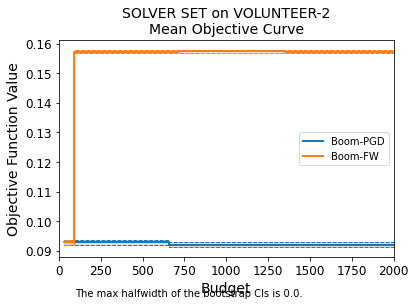

In [54]:
plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_VOLUNTEER-2_mean_prog_curve_unnorm.png']

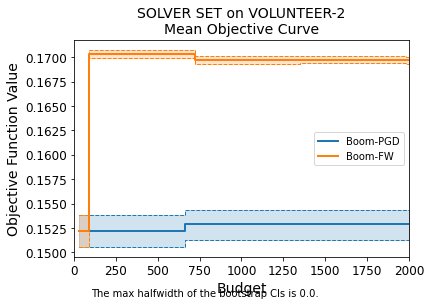

In [40]:
plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_CNTNEWS-1_mean_prog_curve_unnorm.png']

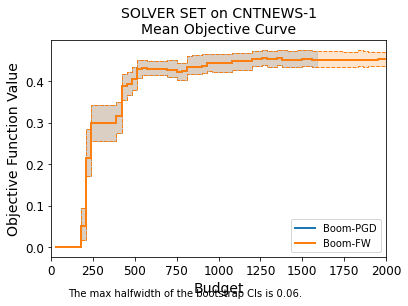

In [46]:
plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

# Queueing

In [7]:
from simopt.models import openjackson

In [8]:
problem_name = "OPENJACKSON"

model_factors = {
    "number_queues": 5,
    "arrival_alphas": [1.0, 4.0, 1.0, 4.0, 0.5],
    "routing_matrix": [[0.1, 0.1, 0.2, 0.2, 0], 
                       [0.1, 0.1, 0.2, 0.2, 0], 
                       [0.2, 0.1, 0, 0.1, 0.2], 
                       [0.1, 0.1, 0.1, 0, 0.2], 
                       [0.1, 0.1, 0.1, 0.1, 0.2]],
    "t_end": 500,
    "warm_up": 200,
    "steady_state_initialization": True
}

pgd_name = "Boom-PGD"
fw_name = "Boom-FW"

file_name_path = "/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/"
pgd_file_path = file_name_path + pgd_name + "_on_" + problem_name + ".pickle"
fw_file_path = file_name_path + fw_name + "_on_" + problem_name + ".pickle"

def pgd_step_size(k):
    return 1/np.sqrt(k+1)

def fw_step_size(k):
    return 1/np.sqrt(k+1)

problem_factors = {
    "budget":1000,
    "initial_solution":(10,10,10,10,10),
    "service_rates_budget":66
}

In [9]:
jackson_problem = openjackson.OpenJacksonMinQueue(fixed_factors = problem_factors,model_fixed_factors = model_factors)

In [10]:
pgd_factors = {
    "step_f":pgd_step_size,
    "max_iters":300,
    "proj_thres":0.1,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":0.7
}

fw_factors = {
    "step_f":fw_step_size,
    "max_iters":300,
    "backtrack":1,
    "theta":0.2,
    "max_gamma":0.7,
    "atom_vectors":None,
    "algorithm":"normal"
}

fw_experiment = ProblemSolver(solver_name=fw_name, 
                             problem_name=problem_name,
                             solver_fixed_factors=fw_factors, 
                             problem_fixed_factors=problem_factors, 
                             model_fixed_factors=model_factors,
                             file_name_path = fw_file_path)

pgd_experiment = ProblemSolver(solver_name=pgd_name, 
                             problem_name=problem_name,
                             solver_fixed_factors=pgd_factors, 
                             problem_fixed_factors=problem_factors, 
                             model_fixed_factors=model_factors,
                             file_name_path = pgd_file_path)

experiments = [pgd_experiment,fw_experiment]


In [11]:
for e in experiments:
    e.run(n_macroreps=1)
    e.post_replicate(n_postreps=100)
    
post_normalize(experiments, n_postreps_init_opt=100)

In [12]:
#path_values = fw_experiment.all_recommended_xs[0]
#path_values = np.array(path_values)
#path_values

['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_OPENJACKSON-1_mean_prog_curve_unnorm.png']

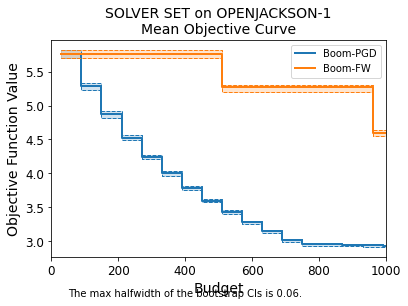

In [13]:
plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)

['/Users/boomts59/Downloads/simopt-python_dev_joe/experiments/outputs/00Try/plots/SOLVER_SET_on_OPENJACKSON-1_mean_prog_curve_unnorm.png']

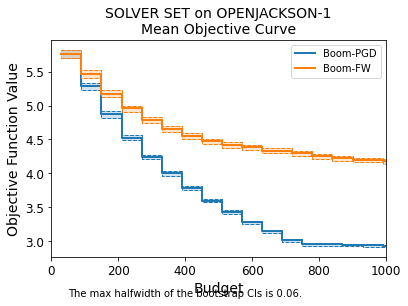

In [13]:
plot_progress_curves(experiments=experiments, plot_type="mean", normalize=False)